# Modeling and Simulation in Python

Chapter 5: Design

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
init = Series([])
init['S'] = 90
init['I'] = 1
init['R'] = 0
init

S    90
I     1
R     0
dtype: int64

In [3]:
init = Series([90, 1, 0], index=['S', 'I', 'R'])
init

S    90
I     1
R     0
dtype: int64

In [4]:
init /= np.sum(init)
init

S    0.989011
I    0.010989
R    0.000000
dtype: float64

In [5]:
def make_system(beta, gamma, init=init):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [6]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)

In [7]:
def update1(system, state):
    """Update the SIR model.
    
    system: System object
    state: Series (s, i, r)
    
    returns: Series (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return Series([s, i, r], index=state.index)

In [8]:
state = update1(sir, init)
state

S    0.985388
I    0.011865
R    0.002747
dtype: float64

In [9]:
def run_model(system, update_func):
    state = system.init
    for i in range(system.t0, system.t_end):
        state = update_func(system, state)
    return state

In [10]:
run_model(sir, update1)

S    0.520819
I    0.000676
R    0.478505
dtype: float64

### Using Series objects

In [11]:
def run_model(system, update_func):
    S = Series([])
    I = Series([])
    R = Series([])

    state = system.init
    S[0], I[0], R[0] = state
    
    for i in range(sir.t0, sir.t_end):
        state = update_func(system, state)
        S[i+1], I[i+1], R[i+1] = state
    
    system.results = S, I, R

In [12]:
sir = make_system(beta, gamma)
run_model(sir, update1)
S, I, R = sir.results

In [13]:
def plot_results(S, I, R):
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Saving figure to file chap05-fig01.pdf


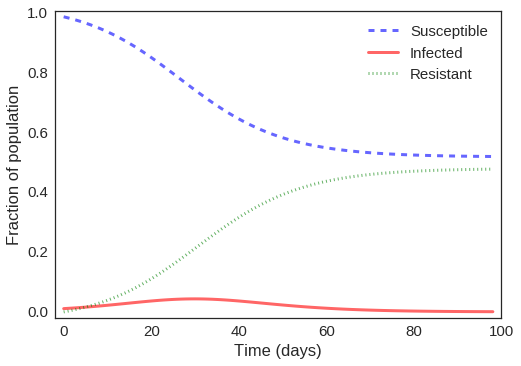

In [14]:
plot_results(S, I, R)
savefig('chap05-fig01.pdf')

### Using a DataFrame

In [15]:
def run_model(system, update_func):
    df = DataFrame(columns=['S', 'I', 'R'])
    df.loc[0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

In [16]:
sir = make_system(beta, gamma)
run_model(sir, update1)
sir.results.head()

,S,I,R
0,0.989011,0.010989,0.000000
1,0.985388,0.011865,0.002747
2,0.981491,0.012795,0.005713
3,0.977305,0.013783,0.008912
4,0.972815,0.014827,0.012358


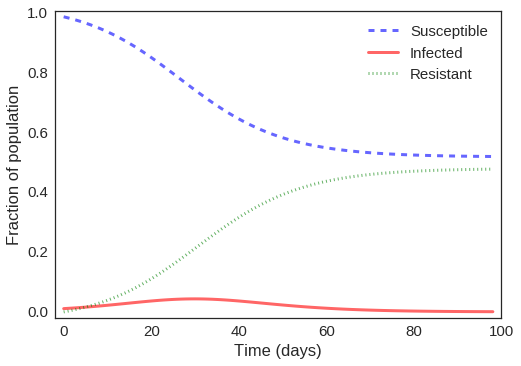

In [17]:
df = sir.results
plot_results(df.S, df.I, df.R)

### Metrics

In [18]:
def calc_total_infected(system):
    df = system.results
    return df.S[system.t0] - df.S[system.t_end]

In [19]:
sir.beta, calc_total_infected(sir)

(0.3333333333333333, 0.46819207410177399)

In [20]:
sir.beta = 0.333
sir.gamma = 0.25
run_model(sir, update1)
print(sir.beta, sir.gamma, calc_total_infected(sir))

0.333 0.25 0.467032714017


In [21]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [22]:
for beta in beta_array:
    sir = make_system(beta, gamma)
    run_model(sir, update1)
    print(sir.beta, calc_total_infected(sir))

0.1 0.00715333115128
0.18 0.0260059625153
0.26 0.159841671698
0.34 0.490761020417
0.42 0.689903615047
0.5 0.804583645575
0.58 0.8737068587
0.66 0.916660636786
0.74 0.943841720738
0.82 0.961176498583
0.9 0.972217579652


### Sweeping beta

In [23]:
def sweep_beta(beta_array, gamma):
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_model(system, update1)
        print(system.beta, calc_total_infected(system))

In [24]:
sweep_beta(beta_array, gamma)

0.1 0.00715333115128
0.18 0.0260059625153
0.26 0.159841671698
0.34 0.490761020417
0.42 0.689903615047
0.5 0.804583645575
0.58 0.8737068587
0.66 0.916660636786
0.74 0.943841720738
0.82 0.961176498583
0.9 0.972217579652


In [25]:
def sweep_beta(beta_array, gamma):
    series = Series()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_model(system, update1)
        series[system.beta] = calc_total_infected(system)
    return series

In [26]:
infected_series = sweep_beta(beta_array, gamma)

Saving figure to file chap05-fig02.pdf


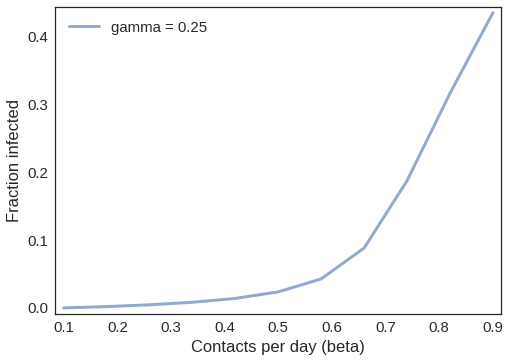

In [51]:
label = 'gamma = ' + str(gamma)
plot(infected_series, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap05-fig02.pdf')

### Sweeping gamma

In [28]:
beta_array = linspace(0.1, 0.9, 11)
beta_array

array([ 0.1 ,  0.18,  0.26,  0.34,  0.42,  0.5 ,  0.58,  0.66,  0.74,
        0.82,  0.9 ])

In [29]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

array([ 0.1,  0.3,  0.5,  0.7])

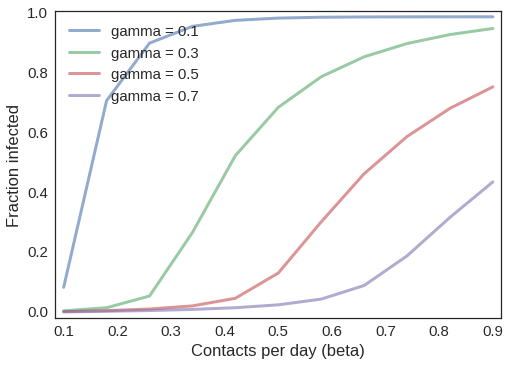

In [30]:
for gamma in gamma_array:
    infected_series = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plot(infected_series, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

In [31]:
def sweep_parameters(beta_array, gamma_array):
    df = DataFrame(columns=gamma_array)
    for gamma in gamma_array:
        df[gamma] = sweep_beta(beta_array, gamma)
    return df

In [32]:
sweep_df = sweep_parameters(beta_array, gamma_array)

In [33]:
sweep_df.head()

,0.1,0.3,0.5,0.7
0.10,0.083964,0.005385,0.002706,0.001807
0.18,0.708468,0.015747,0.006053,0.003742
0.26,0.900880,0.054892,0.011516,0.006358
0.34,0.957004,0.267405,0.021887,0.010082
0.42,0.977165,0.524500,0.047377,0.015778


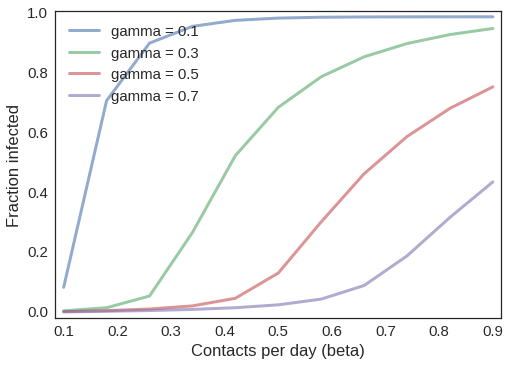

In [34]:
for gamma in gamma_array:
    label = 'gamma = ' + str(gamma)
    plot(sweep_df[gamma], label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

In [35]:
def plot_sweep_df(df):
    for gamma in df.columns:
        series = df[gamma]
        for beta in series.index:
            frac_infected = series[beta]
            plot(beta / gamma, frac_infected, 'ro')

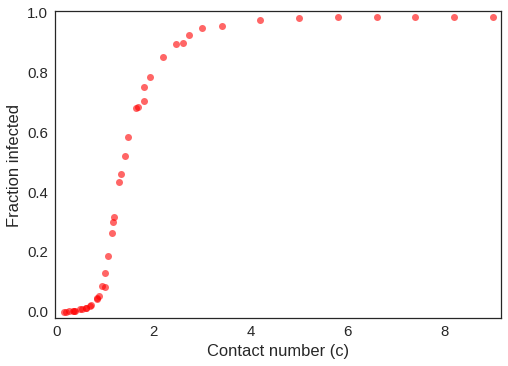

In [36]:
plot_sweep_df(sweep_df)

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected',
         legend=False)

### Analysis

In [37]:
s_inf_array = linspace(0.001, 0.999, 31)
s_inf_array

array([ 0.001     ,  0.03426667,  0.06753333,  0.1008    ,  0.13406667,
        0.16733333,  0.2006    ,  0.23386667,  0.26713333,  0.3004    ,
        0.33366667,  0.36693333,  0.4002    ,  0.43346667,  0.46673333,
        0.5       ,  0.53326667,  0.56653333,  0.5998    ,  0.63306667,
        0.66633333,  0.6996    ,  0.73286667,  0.76613333,  0.7994    ,
        0.83266667,  0.86593333,  0.8992    ,  0.93246667,  0.96573333,
        0.999     ])

In [38]:
c_array = np.log(s_inf_array) / (s_inf_array - 1)
c_array

array([ 6.91466995,  3.49328546,  2.89032742,  2.55184266,  2.32052285,
        2.14703857,  2.00956017,  1.89654211,  1.80115624,  1.71903996,
        1.6472428 ,  1.58368013,  1.52682704,  1.47553609,  1.42892337,
        1.38629436,  1.34709399,  1.3108721 ,  1.2772589 ,  1.24594716,
        1.21667902,  1.18923614,  1.1634321 ,  1.13910658,  1.1161208 ,
        1.09435385,  1.07369982,  1.05406547,  1.03536833,  1.01753508,
        1.00050033])

In [39]:
frac_infected_analysis = Series(1 - s_inf_array, index=c_array)

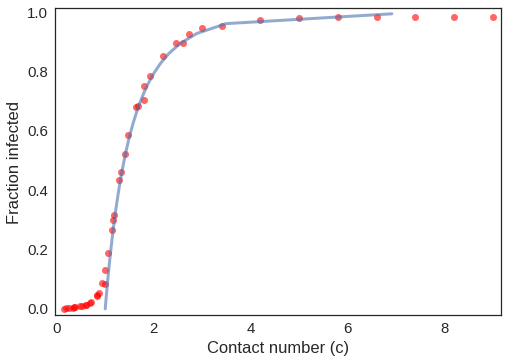

In [40]:
plot_sweep_df(sweep_df)
plot(frac_infected_analysis)

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected',
         legend=False)

### What if?

In [41]:
frac_infected_analysis

6.914670    0.999000
3.493285    0.965733
2.890327    0.932467
2.551843    0.899200
2.320523    0.865933
2.147039    0.832667
2.009560    0.799400
1.896542    0.766133
1.801156    0.732867
1.719040    0.699600
1.647243    0.666333
1.583680    0.633067
1.526827    0.599800
1.475536    0.566533
1.428923    0.533267
1.386294    0.500000
1.347094    0.466733
1.310872    0.433467
1.277259    0.400200
1.245947    0.366933
1.216679    0.333667
1.189236    0.300400
1.163432    0.267133
1.139107    0.233867
1.116121    0.200600
1.094354    0.167333
1.073700    0.134067
1.054065    0.100800
1.035368    0.067533
1.017535    0.034267
1.000500    0.001000
dtype: float64

In [42]:
observed_fraction_infected = 0.3

c = 1.2
gamma = 1 / 4
beta = c * gamma 

sir = make_system(beta, gamma)
sir.beta, sir.gamma

(0.3, 0.25)

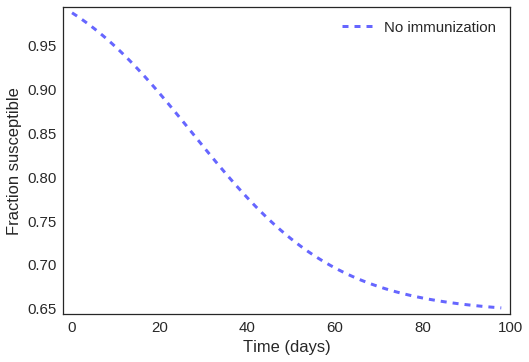

In [43]:
run_model(sir, update1)
plot(sir.results.S, '--', color='blue', label='No immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

In [44]:
calc_total_infected(sir)

0.33666563173764197

In [45]:
def immunize(system, fraction):
    s, i, r = system.init
    s -= fraction
    r += fraction
    system.init = s, i, r

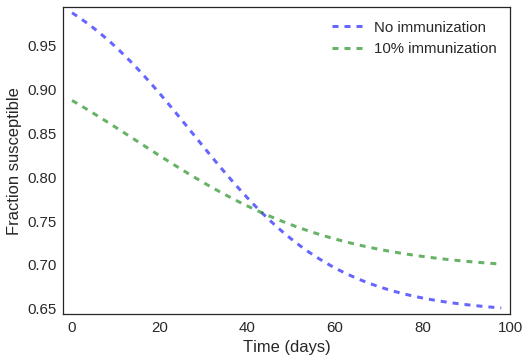

In [46]:
sir2 = make_system(beta, gamma)
immunize(sir2, 0.1)
run_model(sir2, update1)
plot(sir.results.S, '--', color='blue', label='No immunization')
plot(sir2.results.S, '--', color='green', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

In [47]:
calc_total_infected(sir2)

0.18665307678471343

In [48]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    sir = make_system(beta, gamma)
    immunize(sir, fraction)
    run_model(sir, update1)
    print(fraction, calc_total_infected(sir))

0.0 0.336665631738
0.1 0.186653076785
0.2 0.0886085056892
0.3 0.0439958322587
0.4 0.0247367945899
0.5 0.0150655109183
0.6 0.00941950556391
0.7 0.00575381715979
0.8 0.0031921546323
0.9 0.00130469419207
1.0 -0.000142240931426


In [49]:
def sweep_immunity(immunize_array):
    series = Series([])
    for fraction in immunize_array:
        sir = make_system(beta, gamma)
        immunize(sir, fraction)
        run_model(sir, update1)
        series[fraction] = calc_total_infected(sir)
    return series

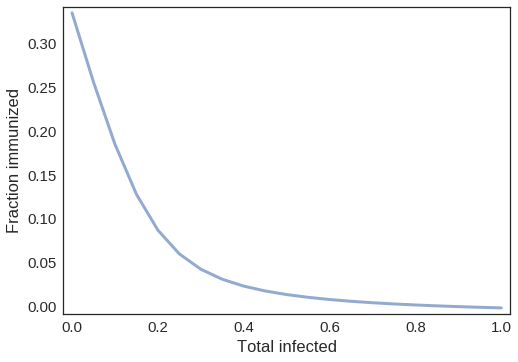

In [50]:
immunize_array = linspace(0, 1, 21)
infected = sweep_immunity(immunize_array)
plot(infected)

decorate(xlabel='Total infected',
         ylabel='Fraction immunized',
         legend=False)